# Create Graphics as Illustration in Text

In this notebook, we want to design a pipeline that create images that related to the corresponding text. Let's start with some text-to-image models.

The OpenAI's [DALL·E](https://openai.com/blog/dall-e/) is one of the most famous text-to-image models, which can take a descriptive sentence as the input and then create an image accordingly. The original DALLE is a huge model, and there is a smaller version, [dalle-mini](https://huggingface.co/flax-community/dalle-mini), available in Higging Face model hub.

Another popular image generator model is [BigGan](https://arxiv.org/abs/1809.11096), a comprehensive introduction (in zh-TW) can be found [here](https://xiaosean5408.medium.com/biggan%E7%B0%A1%E4%BB%8B-large-scale-gan-training-for-high-fidelity-natural-image-synthesis-df349a5f811c). The **BigGan** takes ImgNet text as its input and generates images in the corresponding category. The implementations in various resolutions can be found in both HiggingFace and TensorFlow hub.


## Text to Image Models
- [Hugging Face Repo](https://huggingface.co/models?pipeline_tag=text-to-image&sort=downloads)
    + [dalle-mini](https://huggingface.co/flax-community/dalle-mini)
    + [BigGan](https://huggingface.co/osanseviero/BigGAN-deep-128)
- [TensorFlow Hub](https://tfhub.dev/s?module-type=image-generator)
    + [biggan-deep-512](https://tfhub.dev/deepmind/biggan-deep-512/1)
    + [bigbigan-resnet50](https://tfhub.dev/deepmind/bigbigan-resnet50/1)


## Our Approach
Our goal is to generate images that can support the generated text, such as illustrations in a book of essays and poems. As a result, we may not need images represent exactly described in the text, but images some what related to the text along side. Hence, we can use smaller model to generate the images, and then post-process the outputs to retain relations to the corresponding text.


## [bigbigan-resnet50](https://tfhub.dev/deepmind/bigbigan-resnet50/1)

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

model_url = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'
model = hub.load(model_url)

print(model.signatures.keys())

KeysView(_SignatureMap({'encode': <ConcreteFunction pruned(x) at 0x1AEB569DB08>, 'discriminate': <ConcreteFunction pruned(x, z) at 0x1AEB586CD48>, 'default': <ConcreteFunction pruned(x) at 0x1AEB5C9FA88>, 'generate': <ConcreteFunction pruned(z) at 0x1AEBFEB8E48>}))


In [21]:
z = tf.random.normal([8, 120])                # latent samples
gen_samples = model.signatures['generate'](z)

gen_samples.keys()

dict_keys(['default', 'upsampled'])

In [22]:
print(gen_samples['default'].shape)
print(gen_samples['upsampled'].shape)

(8, 128, 128, 3)
(8, 256, 256, 3)


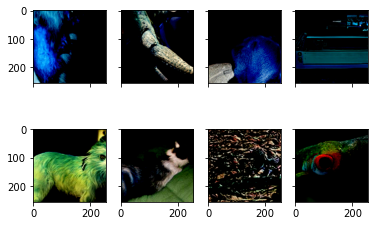

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = np.array(gen_samples['upsampled'])

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
for i in range(images.shape[0]):
    axs[int(i/4), i%4].imshow(np.flip(images[i,:,:,:],2))
plt.show()

In [27]:
tf.saved_model.save(model, 'D:/workspace/image_generation_models/biggan-resnet50')

INFO:tensorflow:Assets written to: D:/workspace/image_generation_models/biggan-resnet50\assets


INFO:tensorflow:Assets written to: D:/workspace/image_generation_models/biggan-resnet50\assets
